<a href="https://colab.research.google.com/github/Analcrs6/Heart-Failure-Clinical-Records-/blob/main/Heart_Failure_Clinical_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Libraries for Interpretability/Explainability
!pip install eli5
!pip install lime
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=571a03272246f9d916d36815044efd0649f038714d55bb5ce3183331ede8e956
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


# Project Summary: Heart Failure Prediction & Interpretability

## Overview
This project aims to predict the survival of patients with heart failure using clinical records and, crucially, to explain the predictions using various Machine Learning Interpretability (XAI) techniques. By comparing 'Glass Box' models (Logistic Regression, Decision Trees) with 'Black Box' models (Random Forest, XGBoost), the project balances predictive performance with transparency.

## Dataset
The analysis uses the **Heart Failure Clinical Records Data**, comprising 299 patients and 13 clinical features (e.g., age, ejection fraction, serum creatinine). The target variable is `DEATH_EVENT`.

## Methodology
1.  **Exploratory Data Analysis (EDA)**: Investigated distributions, correlations, and outliers. Key drivers identified included `time`, `serum_creatinine`, and `ejection_fraction`.
2.  **Model Training**: Implemented and hyperparameter-tuned four classifiers:
    *   Logistic Regression
    *   Decision Tree
    *   Random Forest
    *   XGBoost
3.  **Explainability (XAI)**: Utilized state-of-the-art libraries to interpret model behavior:
    *   **ELI5**: Global feature weights and permutation importance.
    *   **LIME**: Local surrogate models to explain individual predictions for complex models.
    *   **SHAP**: Game-theoretic approach for consistent global and local feature attribution.

## Results
*   **Performance**: The **Random Forest** model achieved the best results with an **Accuracy of ~83%** and an **AUC-ROC of ~0.91**.
*   **Key Findings**: Across all models and XAI methods, **follow-up time**, **serum creatinine**, and **ejection fraction** consistently emerged as the most critical predictors of patient survival.

## Tools & Libraries
*   **Core**: Python, Pandas, Scikit-learn, XGBoost
*   **Visualization**: Matplotlib, Seaborn
*   **XAI**: ELI5, LIME, SHAP

In [ ]:
# Set plotting style
sns.set_style("whitegrid")

# Load the dataset
# Ensure the CSV file is accessible in your notebook environment
df = pd.read_csv('/content/heart+failure+clinical+records.zip')

EDA

In [ ]:
# print info
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None
             

In [ ]:
print(df.isnull().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


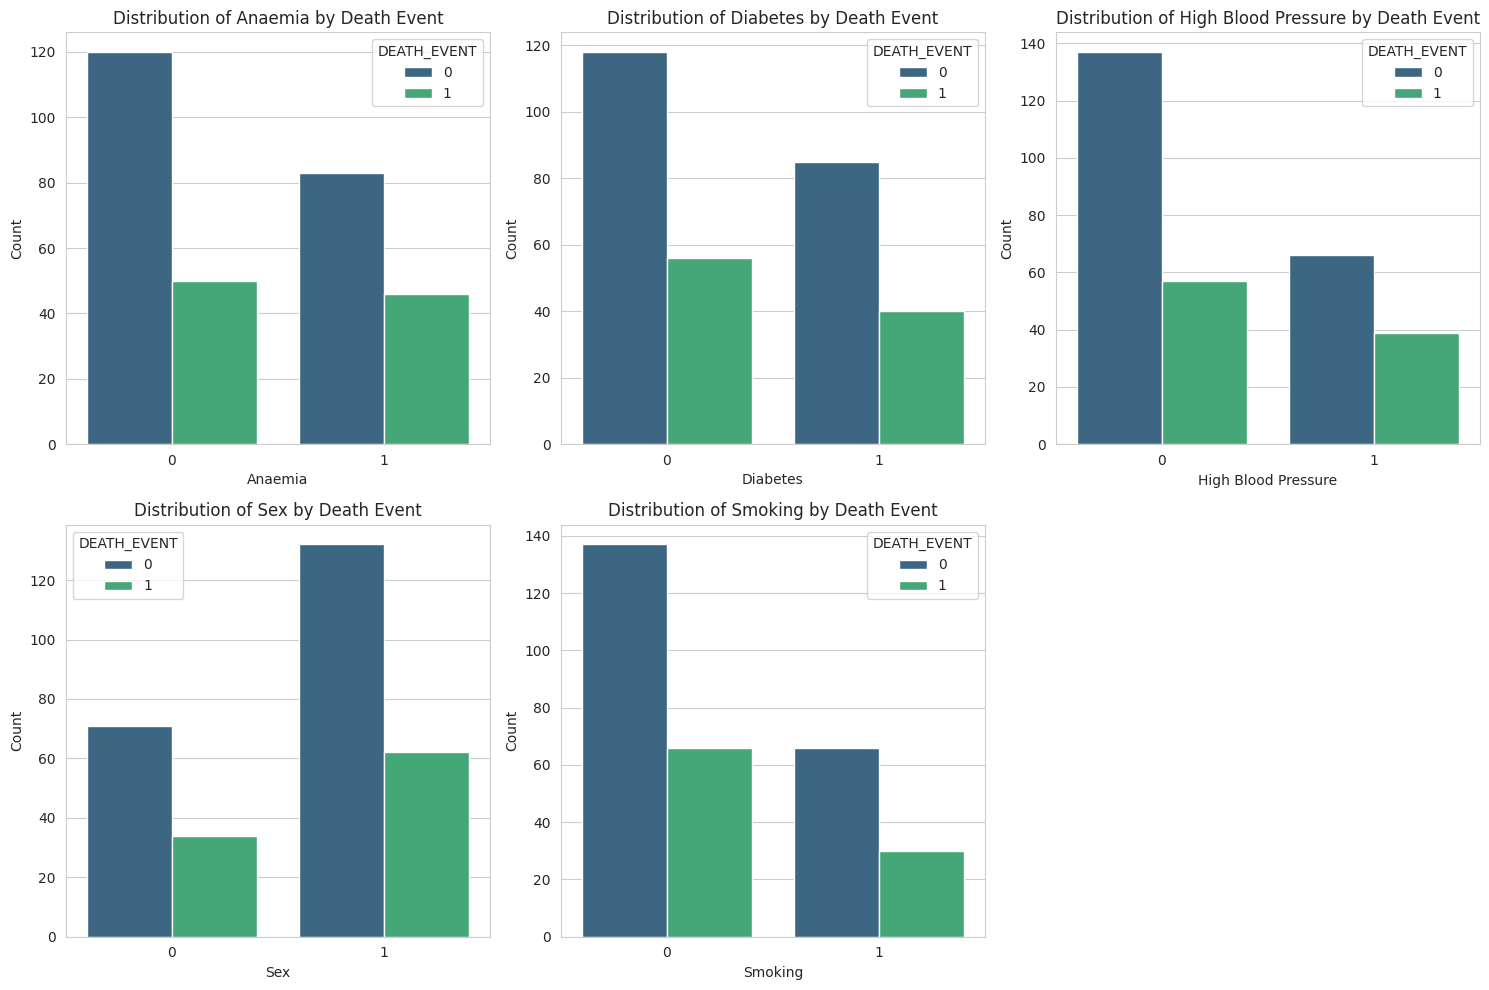

In [ ]:
binary_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(binary_features):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=feature, hue='DEATH_EVENT', data=df, palette='viridis')
    plt.title(f'Distribution of {feature.replace("_", " ").title()} by Death Event')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

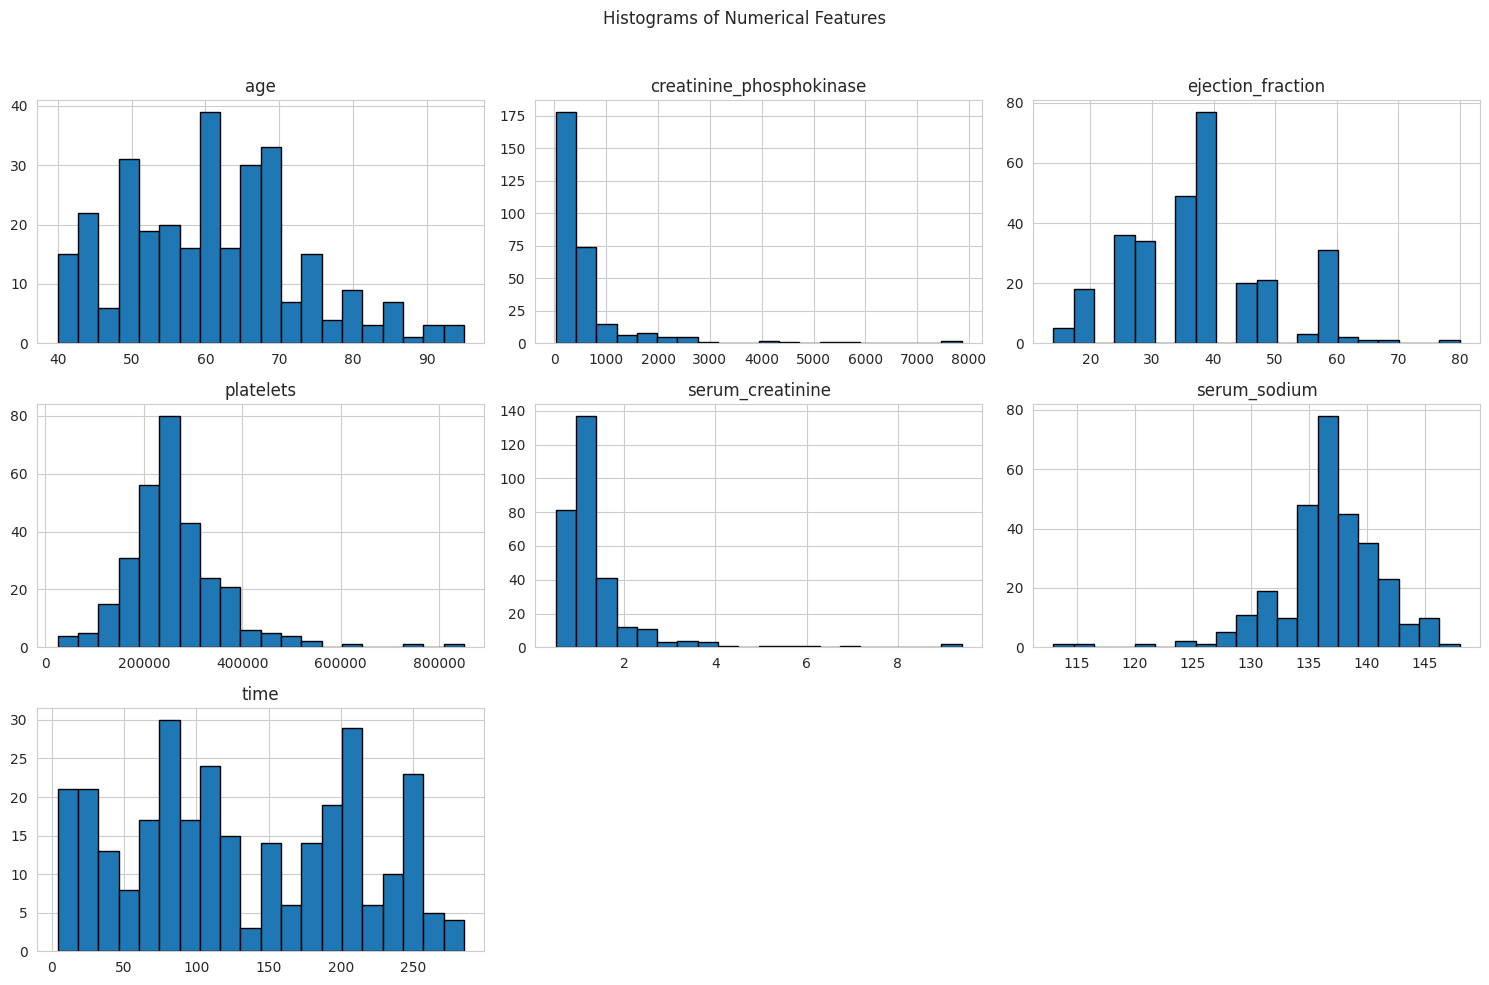

In [ ]:
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                      'platelets', 'serum_creatinine', 'serum_sodium', 'time']

# 1. Histograms for Distribution
df[numerical_features].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/tmp/ipython-input-971710804.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[feature], palette='Spectral')
/tmp/ipython-input-971710804.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[feature], palette='Spectral')
/tmp/ipython-input-971710804.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[feature], palette='Spectral')
/tmp/ipython-input-971710804.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for

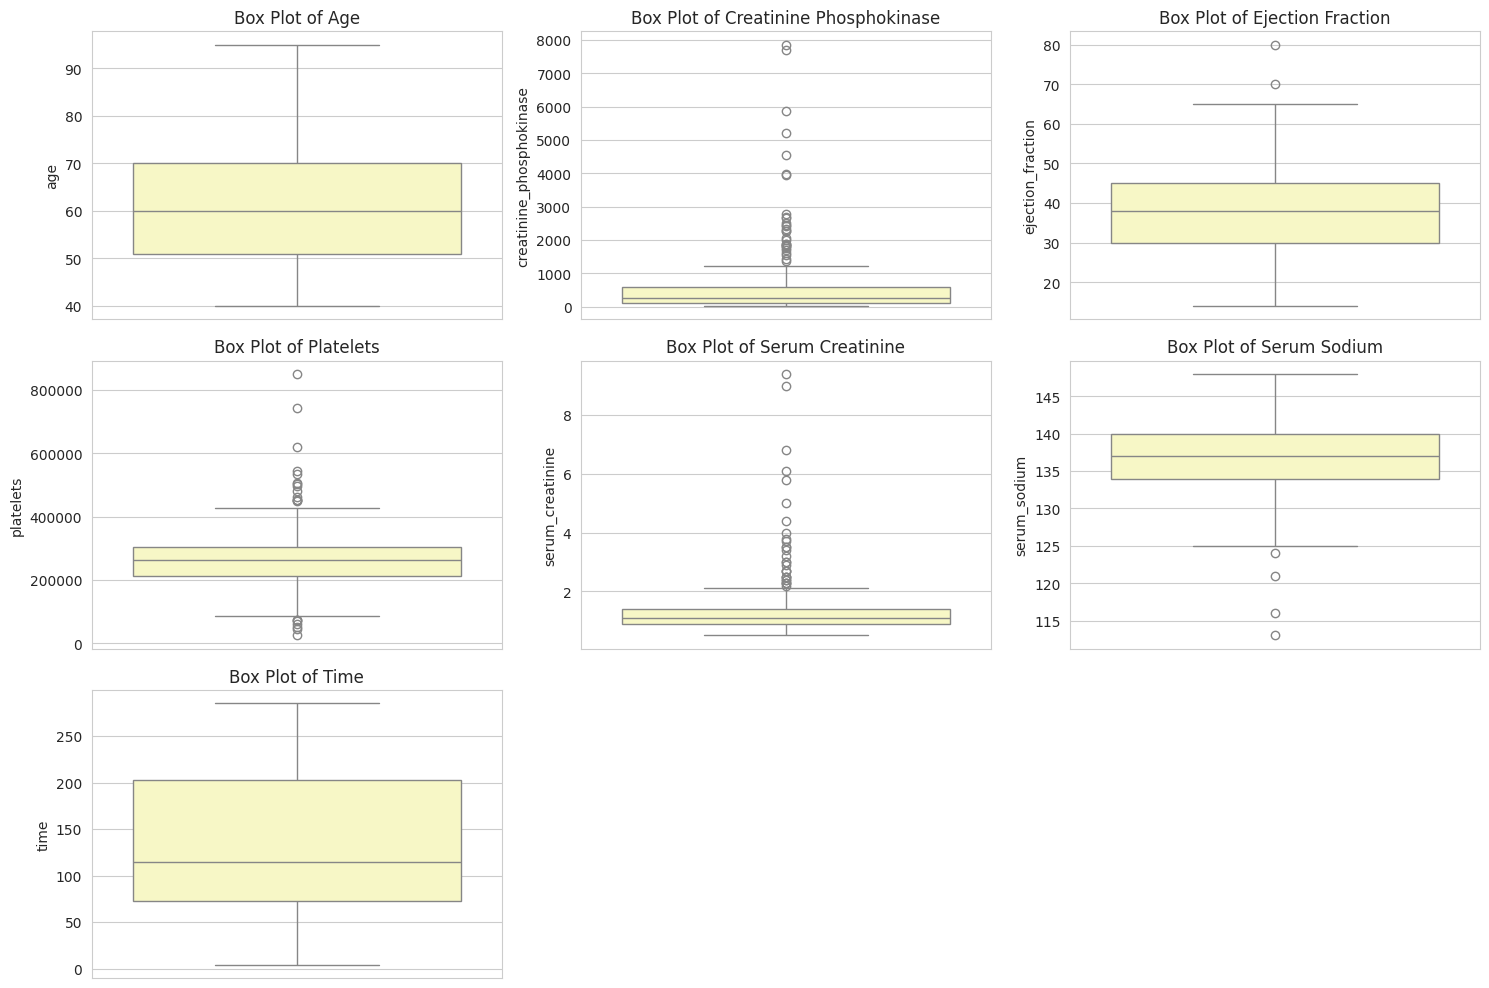

In [ ]:
# 2. Box Plots for Outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[feature], palette='Spectral')
    plt.title(f'Box Plot of {feature.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

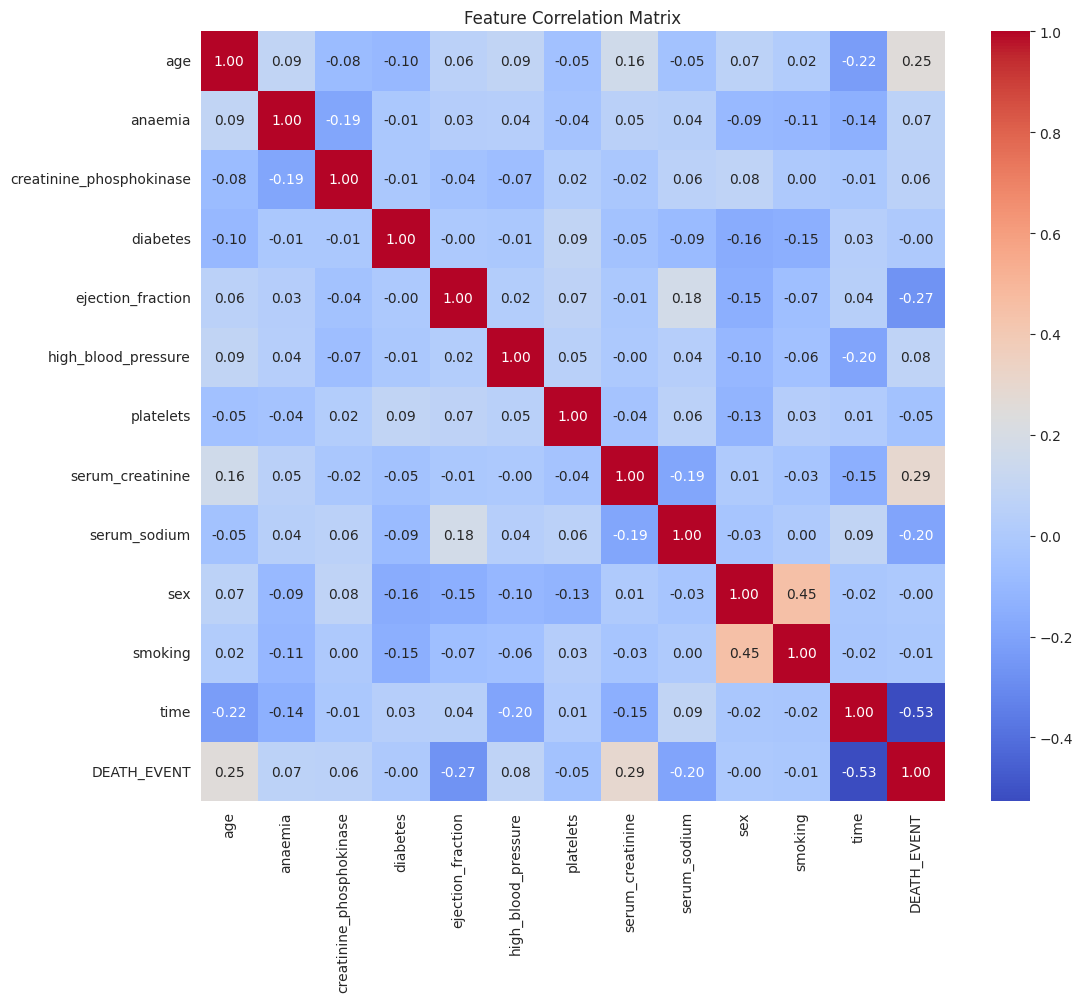


--- Correlation with DEATH_EVENT ---
DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

# Display correlation with the target variable
print("\n--- Correlation with DEATH_EVENT ---")
print(correlation_matrix['DEATH_EVENT'].sort_values(ascending=False))

Data Preparation

In [ ]:
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Model tuning function

In [ ]:
def tune_model(model, param_grid, model_name):
    print(f"--- Tuning {model_name} ---")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

    # Fit to the training data
    grid_search.fit(X_train, y_train)

    # Best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Best Hyperparameters: {best_params}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC-ROC: {roc_auc:.4f}\n")

    return best_model, accuracy, roc_auc, best_params

# Dictionary to store results
results = {}

Logistic Regression

In [ ]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

best_lr, acc_lr, auc_lr, params_lr = tune_model(lr_model, lr_param_grid, "Logistic Regression (LR)")
results['LR'] = {'model': best_lr, 'accuracy': acc_lr, 'auc_roc': auc_lr, 'params': params_lr}

--- Tuning Logistic Regression (LR) ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 100}
Test Accuracy: 0.8167
Test AUC-ROC: 0.8549



Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 5, 10]
}

best_dt, acc_dt, auc_dt, params_dt = tune_model(dt_model, dt_param_grid, "Decision Tree (DT)")
results['DT'] = {'model': best_dt, 'accuracy': acc_dt, 'auc_roc': auc_dt, 'params': params_dt}

--- Tuning Decision Tree (DT) ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 10}
Test Accuracy: 0.8333
Test AUC-ROC: 0.8620



Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

best_rf, acc_rf, auc_rf, params_rf = tune_model(rf_model, rf_param_grid, "Random Forest (RF)")
results['RF'] = {'model': best_rf, 'accuracy': acc_rf, 'auc_roc': auc_rf, 'params': params_rf}

--- Tuning Random Forest (RF) ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Test Accuracy: 0.8333
Test AUC-ROC: 0.9076



XGBoost

In [ ]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

best_xgb, acc_xgb, auc_xgb, params_xgb = tune_model(xgb_model, xgb_param_grid, "XGBoost (XGB)")
results['XGB'] = {'model': best_xgb, 'accuracy': acc_xgb, 'auc_roc': auc_xgb, 'params': params_xgb}

--- Tuning XGBoost (XGB) ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Test Accuracy: 0.8167
Test AUC-ROC: 0.8318



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:45:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Machine Learning Interpretability/Explainability (XAI)

In [ ]:
# Visualize weights (coefficients)
print("--- LR Feature Weights (Coefficients) ---")
# The weights are interpreted as the change in the log-odds of the positive class (DEATH_EVENT=1)
# for a one-unit increase in the feature value.
display(eli5.show_weights(best_lr, feature_names=list(X_train.columns)))

# Explain specific predictions
# Find a positive and a negative case in the test set
# Assuming index 0 is negative (0: Survived) and index 1 is positive (1: Deceased)
neg_idx = y_test[y_test == 0].index[0]
pos_idx = y_test[y_test == 1].index[0]

# Negative prediction (Should be 0 - Survived)
print("\n--- LR Explanation for Negative Case (DEATH_EVENT=0) ---")
display(eli5.show_prediction(best_lr, X_test.loc[neg_idx], feature_names=list(X_train.columns),
                            show_feature_values=True))

# Positive prediction (Should be 1 - Deceased)
print("\n--- LR Explanation for Positive Case (DEATH_EVENT=1) ---")
display(eli5.show_prediction(best_lr, X_test.loc[pos_idx], feature_names=list(X_train.columns),
                            show_feature_values=True))

--- LR Feature Weights (Coefficients) ---


Weight?,Feature
+0.029,age
+0.013,serum_sodium
+0.006,serum_creatinine
+0.001,diabetes
+0.000,anaemia
+0.000,creatinine_phosphokinase
+0.000,<BIAS>
+0.000,high_blood_pressure
-0.000,platelets
-0.000,smoking



--- LR Explanation for Negative Case (DEATH_EVENT=0) ---



--- LR Explanation for Positive Case (DEATH_EVENT=1) ---


In [ ]:
# Feature Importance (based on Gini impurity/information gain)
print("--- DT Feature Importance ---")
display(eli5.show_weights(best_dt, feature_names=list(X_train.columns)))

# Explain specific predictions
# Use the same indices as for LR

# Negative prediction (Should be 0 - Survived)
print("\n--- DT Explanation for Negative Case (DEATH_EVENT=0) ---")
# The explanation follows the decision path [cite: 52]
display(eli5.show_prediction(best_dt, X_test.loc[neg_idx], feature_names=list(X_train.columns),
                            show_feature_values=True))

# Positive prediction (Should be 1 - Deceased)
print("\n--- DT Explanation for Positive Case (DEATH_EVENT=1) ---")
display(eli5.show_prediction(best_dt, X_test.loc[pos_idx], feature_names=list(X_train.columns),
                            show_feature_values=True))

--- DT Feature Importance ---


Weight,Feature
0.7557,time
0.1457,serum_creatinine
0.0593,ejection_fraction
0.0392,serum_sodium
0,sex
0,smoking
0,platelets
0,high_blood_pressure
0,diabetes
0,creatinine_phosphokinase



--- DT Explanation for Negative Case (DEATH_EVENT=0) ---



--- DT Explanation for Positive Case (DEATH_EVENT=1) ---


In [ ]:
# Initialize LIME Explainer
# training_data is X_train (must be numpy array)
# feature_names are column names
# class_names are the target labels (0 and 1)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Survived', 'Deceased'], # Assuming 0=Survived, 1=Deceased
    mode='classification',
    random_state=42
)

# Explainers for RF and XGB
models_to_explain_lime = {
    'Random Forest (RF)': best_rf,
    'XGBoost (XGB)': best_xgb
}

# Use the same indices
sample_indices = {'Negative Case (0)': neg_idx, 'Positive Case (1)': pos_idx}

for model_name, model in models_to_explain_lime.items():
    print(f"\n--- LIME Explanation for {model_name} ---")

    for case_name, idx in sample_indices.items():
        print(f"\n--- {case_name} (True Label: {y_test.loc[idx]}) ---")

        # Generate the explanation for the specific instance
        exp = explainer_lime.explain_instance(
            data_row=X_test.loc[idx].values,
            predict_fn=model.predict_proba,
            num_features=5 # Show top 5 features
        )

        # Access and print LIME's internal model details
        # The 'local_model' attribute does not exist in this version.
        # We can access the R^2 score to judge the local model's quality.
        print(f"Local Model Fidelity (R^2): {exp.score:.4f}")

        # exp.show_in_notebook(show_table=True)

        print("\nLocal Linear Model Coefficients (Top Features):")
        # exp.as_list() returns features and their contribution
        print(exp.as_list())

        # Crucial Note: If R^2 is low, the explanation may not be reliable.


--- LIME Explanation for Random Forest (RF) ---

--- Negative Case (0) (True Label: 0) ---
Local Model Fidelity (R^2): 0.2136

Local Linear Model Coefficients (Top Features):
[('time > 197.50', -0.17338706475514354), ('ejection_fraction <= 30.00', 0.14860152361492993), ('0.90 < serum_creatinine <= 1.10', -0.05859741500809026), ('platelets <= 212500.00', 0.040576776542065075), ('253.00 < creatinine_phosphokinase <= 582.00', 0.023429936576512128)]

--- Positive Case (1) (True Label: 1) ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Local Model Fidelity (R^2): 0.0832

Local Linear Model Coefficients (Top Features):
[('69.50 < time <= 112.00', -0.10250861055602642), ('age > 69.50', 0.06226832662607535), ('serum_sodium <= 134.00', 0.061064272825170254), ('ejection_fraction > 45.00', -0.06009231889778957), ('1.10 < serum_creatinine <= 1.40', -0.0353429230157343)]

--- LIME Explanation for XGBoost (XGB) ---

--- Negative Case (0) (True Label: 0) ---
Local Model Fidelity (R^2): 0.3115

Local Linear Model Coefficients (Top Features):
[('time > 197.50', -0.33757994658116897), ('ejection_fraction <= 30.00', 0.2567351633025744), ('0.90 < serum_creatinine <= 1.10', -0.07924132691791345), ('platelets <= 212500.00', 0.07723410830289186), ('0.00 < sex <= 1.00', -0.04682225703091593)]

--- Positive Case (1) (True Label: 1) ---
Local Model Fidelity (R^2): 0.1046

Local Linear Model Coefficients (Top Features):
[('69.50 < time <= 112.00', -0.2348125537114422), ('ejection_fraction > 45.00', -0.10345792792163154), ('0.00 < sex <= 1

SHAP Base Value (Expected Value): -0.7691

--- SHAP Force Plot for Negative Case (DEATH_EVENT=0) ---



--- SHAP Force Plot for Positive Case (DEATH_EVENT=1) ---



--- SHAP Summary Plot (Feature Importance) ---


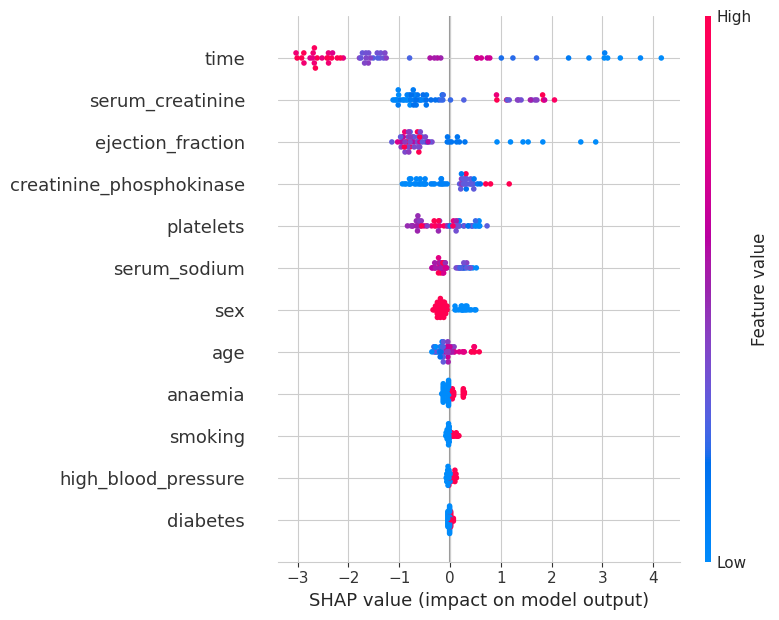

In [ ]:
# Initialize SHAP Tree Explainer
explainer_shap = shap.TreeExplainer(best_xgb)
# Calculate SHAP values for the test set
shap_values = explainer_shap.shap_values(X_test)
# The base value (expected value) is the average model output (expected value of the prediction function)
base_value = explainer_shap.expected_value
print(f"SHAP Base Value (Expected Value): {base_value:.4f}")

# Get integer locations (positional indices) for the specific cases
iloc_neg = X_test.index.get_loc(neg_idx)
iloc_pos = X_test.index.get_loc(pos_idx)

# Visualize explanations using force_plot for specific predictions
# Negative Prediction (Index neg_idx)
print("\n--- SHAP Force Plot for Negative Case (DEATH_EVENT=0) ---")
# Use init_js() once at the start of the SHAP section if not running in a notebook that auto-renders JS
shap.initjs()
display(shap.force_plot(
    base_value=base_value,
    shap_values=shap_values[iloc_neg],
    features=X_test.iloc[iloc_neg]
))

# Positive Prediction (Index pos_idx)
print("\n--- SHAP Force Plot for Positive Case (DEATH_EVENT=1) ---")
display(shap.force_plot(
    base_value=base_value,
    shap_values=shap_values[iloc_pos],
    features=X_test.iloc[iloc_pos]
))


# Create Feature Importance Summary Plot
print("\n--- SHAP Summary Plot (Feature Importance) ---")
# SHAP Summary plot visualizes the impact of features for all samples
shap.summary_plot(shap_values, X_test)

In [ ]:
# Select the same two observations from the test set
X_neg = X_test.loc[[neg_idx]]
X_pos = X_test.loc[[pos_idx]]

def print_predictions(X_obs, true_label):
    print(f"\nObservation (True Label: {true_label}):\n{X_obs.iloc[0].to_dict()}")
    print("-------------------------------------------------------")

    # Store probability results
    prob_results = {}

    for name, model in models_to_explain_lime.items():
        prob_results[name] = model.predict_proba(X_obs)[0]

    # Add LR and DT
    prob_results['Logistic Regression (LR)'] = results['LR']['model'].predict_proba(X_obs)[0]
    prob_results['Decision Tree (DT)'] = results['DT']['model'].predict_proba(X_obs)[0]

    # Display output as requested (prob_T prob_F - though typically it is [prob_0, prob_1]) [cite: 70, 71, 72, 73, 74]
    # Assuming prob_T (True label) is the actual class probability and prob_F is the opposite.
    # Let's use [prob_Label_0, prob_Label_1] for clarity, where Label 1 is 'T' if True label is 1, and 'F' if True label is 0.
    # The output format requested is: * LR: [prob_T prob_F] [cite: 71]

    print("--- Model Predictions (Probabilities [P(0), P(1)]) ---")

    for name, probs in prob_results.items():
        # probs[0] is P(Label 0: Survived), probs[1] is P(Label 1: Deceased)

        # Map to the requested output format [prob_T prob_F]
        # P_T = P(True Label)
        # P_F = P(False Label)
        if true_label == 1: # True label is 1
            P_T = probs[1]
            P_F = probs[0]
        else: # True label is 0
            P_T = probs[0]
            P_F = probs[1]

        print(f"* {name.split('(')[-1].replace(')','').strip()}: [{P_T:.4f} {P_F:.4f}]")

# Predict for the Negative Case (True Label: 0 - Survived)
print_predictions(X_neg, 0)

# Predict for the Positive Case (True Label: 1 - Deceased)
print_predictions(X_pos, 1)

# Summarize the model accuracy
print("\n--- Summary of Model Test Accuracy and AUC-ROC ---")
for name, data in results.items():
    print(f"**{name}**: Accuracy={data['accuracy']:.4f}, AUC-ROC={data['auc_roc']:.4f}")


Observation (True Label: 0):
{'age': 60.0, 'anaemia': 1.0, 'creatinine_phosphokinase': 257.0, 'diabetes': 1.0, 'ejection_fraction': 30.0, 'high_blood_pressure': 0.0, 'platelets': 150000.0, 'serum_creatinine': 1.0, 'serum_sodium': 137.0, 'sex': 1.0, 'smoking': 1.0, 'time': 245.0}
-------------------------------------------------------
--- Model Predictions (Probabilities [P(0), P(1)]) ---
* RF: [0.8419 0.1581]
* XGB: [0.9774 0.0226]
* LR: [0.9652 0.0348]
* DT: [0.9680 0.0320]

Observation (True Label: 1):
{'age': 85.0, 'anaemia': 0.0, 'creatinine_phosphokinase': 129.0, 'diabetes': 0.0, 'ejection_fraction': 60.0, 'high_blood_pressure': 0.0, 'platelets': 306000.0, 'serum_creatinine': 1.2, 'serum_sodium': 132.0, 'sex': 1.0, 'smoking': 1.0, 'time': 90.0}
-------------------------------------------------------
--- Model Predictions (Probabilities [P(0), P(1)]) ---
* RF: [0.3752 0.6248]
* XGB: [0.0130 0.9870]
* LR: [0.2555 0.7445]
* DT: [0.0320 0.9680]

--- Summary of Model Test Accuracy and